# Load modules

In [5]:
import pandas as pd
import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F
import os
import numpy as np
import random
import re
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import math
import torchvision
from IPython.display import display, HTML
from IPython.display import display
display(HTML("<style>.container { width:70% !important; }</style>"))

from useful_functions_notebook_8to13 import *
from functions import *

# Load datasets

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = torch.load('data/dataset_distlognorm_massnorm.pt')
print(dataset[:, 0].mean(), dataset[:, 1].mean())
# mean dist should be 0.0726
# mean mass should be 0.1852

six_branches = torch.load('data/six_branch_norm.pt')
print(six_branches[:, 0].mean(), six_branches[:, 1].mean())
# mean dist should be 0.0633
# mean mass should be 0.1668

ten_branches = torch.load('data/ten_branches_norm.pt')
print(ten_branches[:, 0].mean(), ten_branches[:, 1].mean())
# mean dist should be 0.0633
# mean mass should be 0.1668

tensor(0.0726, dtype=torch.float64) tensor(0.1852, dtype=torch.float64)
tensor(0.0633, dtype=torch.float64) tensor(0.1668, dtype=torch.float64)
tensor(0.1117, dtype=torch.float64) tensor(0.2414, dtype=torch.float64)


# remove empty branches so data have correct shape as in paper

data should have shape (bs, 3, 29, 6)

In [29]:
six_dataset = six_branches[:, :, :, :6]
six_dataset.shape

torch.Size([8161, 3, 29, 6])

# create simple Conv GAN

In [25]:
class Discriminator(nn.Module):
    def __init__(self, nvar, nbr):
        super().__init__()

        self.num_branches = nbr

        self.layers = nn.Sequential(
            nn.Conv2d(nvar, 16, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.Conv2d(16, 32, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Conv2d(64, 128, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Conv2d(128, 256, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Flatten()
        )

        if self.num_branches == 6:
            self.linear = nn.Linear(11776, 1)
        else:
            self.linear = nn.Linear(35328, 1)

    def forward(self, x):
        x = self.layers(x)
        x = self.linear(x)
        return x


class Encoder(nn.Module):
    def __init__(self, nvar, nbr, latent_size):
        super().__init__()

        self.num_branches = nbr

        self.layers = nn.Sequential(
            nn.Conv2d(nvar, 16, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.Conv2d(16, 32, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Conv2d(64, 128, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Conv2d(128, 256, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Flatten()
            )
        
        if self.num_branches == 6:
            self.linear = nn.Linear(11776, latent_size)
        else:
            self.linear = nn.Linear(35328, latent_size)

    def forward(self, x, t = 0):
        x = self.layers(x)
        x = self.linear(x)
        return x


class Generator(nn.Module):
    def __init__(self, nvar, nbr, latent_size):
        super().__init__()

        self.num_branches = nbr

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(32, 16, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(16, nvar, kernel_size=(1, 3), stride=1),
            #nn.Sigmoid()
            nn.ReLU()
        )
        
        if self.num_branches == 6:
            self.linear = nn.Linear(latent_size, 11776)
        else:
            self.linear = nn.Linear(latent_size, 35328)
        self.elu = nn.ELU()


    def forward(self, x, t = 0):
        x = self.elu(self.linear(x))
        if self.num_branches == 6:
            x = x.view(-1, 256, 23, 2)
        else:
            x = x.view(-1, 256, 23, 6)

        return self.layers(x)
        

# reconstruction loss, classic generator loss and classic discriminator loss

In [26]:
def custom_reconstruction_loss(output, target, scale = 10):
    # Calculate the reconstruction loss
    recon_loss = F.mse_loss(output, target, reduction='none')
    
    # Apply higher penalty if target is zero
    penalty = torch.where((target == 0.0) |(target == 0.5) | (target == 1.0), scale * recon_loss, recon_loss)
    
    # Calculate the mean loss
    mean_loss = torch.mean(penalty)
    
    return mean_loss

def generator_classic_loss(disc_gen_values, epsilon = 1e-5):
    
    loss = 1 / len(disc_gen_values) * torch.sum(torch.log(disc_gen_values + epsilon))
    
    return loss



def discriminator_classic_loss(disc_real_values, disc_gen_values, epsilon = 1e-5):
    
    loss = 1 / len(disc_gen_values) * torch.sum(torch.log(disc_real_values + epsilon) + torch.log(1 - disc_gen_values + epsilon))
    
    return loss

# training loops

# successful attempt #1

### - only data with 6 branches
### - BCEWithLogitsLoss
### - recon scale = 10
### - num_train_gen = 1
### - uniform noise

Epoch: 1 / 1
Training generator


100%|███████████████████████████████████████████| 64/64 [01:30<00:00,  1.42s/it]

real image:


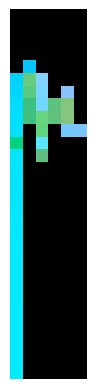

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


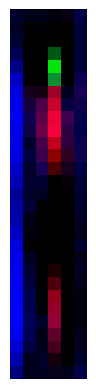

random created images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


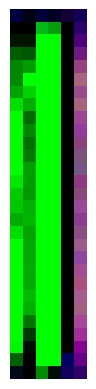

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


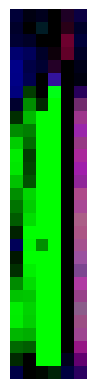

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


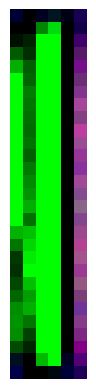

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


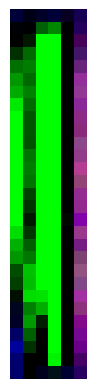

Epoch [0/1]Discriminator Loss: 0.0151, Generator Loss: 13.2805
tensor([[17.4213],
        [-1.7431],
        [ 9.0926]], requires_grad=True)
tensor([[-22.3774],
        [-21.4702],
        [-13.3322]], requires_grad=True)
mean disc rating of real images: tensor(13.4493)
mean disc rating of fake images: tensor(-12.3625)


In [30]:
nsnap = six_dataset.shape[2]
nbr = six_dataset.shape[3]
nvar = six_dataset.shape[1]
printer = False

num_epochs = 1
lr = 3e-4
batch_size = 128
latent_dim = 300

dataloader = DataLoader(six_dataset, shuffle=True, batch_size = batch_size)

discriminator = Discriminator(nvar, nbr).to(device)
encoder = Encoder(nvar, nbr, latent_dim).to(device)
generator = Generator(nvar, nbr, latent_dim).to(device)

optimizer_enc_dec = optim.Adam(list(encoder.parameters()) + list(generator.parameters()), lr=3e-4)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=3e-4)

# Define loss function
criterion = nn.BCEWithLogitsLoss()

num_train_gen = 1
noise_uniform = True
custom_loss = False
recon_scale = 10

for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1} / {num_epochs}")
    if epoch % num_train_gen == 0: 
        print("Training generator")
        
    discriminator.train()
    encoder.train()
    generator.train()
    for real_images in tqdm.tqdm(dataloader):
        bs = real_images.shape[0]
        # Train Discriminator
        discriminator.zero_grad()
        real_images = real_images.to(dtype=torch.float32).to(device)

        # Discriminator forward pass with real images
        real_output = discriminator(real_images).view(-1, 1)
        
        # Generate fake images
        if noise_uniform:
            high = 1.0
            low = -1.0
            uniform_noise = torch.rand(bs, latent_dim) * (high - (low)) + (low)
            noise = uniform_noise.to(device)
        
        else:
            noise = torch.randn(bs, latent_dim).to(device)
        fake_images = generator(noise)

        inputs = torch.cat([real_images, fake_images.detach()])
        labels = torch.cat([torch.ones(bs, 1), torch.zeros(bs, 1)]) # fake
        
        # Discriminator forward pass with fake images
        fake_output = discriminator(fake_images.detach()).view(-1, 1)
        output = discriminator(inputs)
        if custom_loss:
            fake_loss = - discriminator_classic_loss(real_output, fake_output)
        else:
            fake_loss = criterion(output, labels)
        
        # Backpropagate and update discriminator weights
        d_loss = fake_loss
        d_loss.backward()
        optimizer_discriminator.step()
        
        if epoch % num_train_gen == 0: 
            # Train Generator (Encoder + Decoder)
            encoder.zero_grad()
            generator.zero_grad()

            recon = encoder(real_images)
            recon_images = generator(recon)
            output = discriminator(fake_images).view(-1, 1)

            # Generator loss
            if custom_loss:
                g_loss = -generator_classic_loss(output)
            else:
                real_labels = torch.ones(bs, 1)
                g_loss = criterion(output, real_labels)
                
            loss_rec = custom_reconstruction_loss(real_images, recon_images) * recon_scale

            loss_g = g_loss + loss_rec
            # Backpropagate and update generator weights
            loss_g.backward()
            optimizer_enc_dec.step()
        
        # Print losses
        
    if epoch % 1 == 0 or epoch + 1 == num_epochs:
        with torch.no_grad():
            discriminator.eval()
            encoder.eval()
            generator.eval()

            print("real image:")
            test = real_images[0]
            img = test.permute(1, 2, 0).detach().numpy()
            plt.imshow(img)
            plt.axis('off')  # Optional: Turn off axis ticks and labels
            plt.show()

            print("reconstructed image:")
            real = real_images.to(dtype=torch.float32)
            encoded = encoder(real)
            reconstructed = generator(encoded)
            recon = reconstructed.reshape(-1, nvar, nsnap, nbr)
            img = recon[0].permute(1, 2, 0).detach().numpy()
            plt.imshow(img)
            plt.axis('off')  # Optional: Turn off axis ticks and labels
            plt.show()


            # generate and show fake images
            print("random created images:")
            fixed_noise = torch.randn((batch_size, latent_dim)).to(device)
            fake = generator(fixed_noise).reshape(-1, nvar, nsnap, nbr)
            im = random.randint(0, batch_size - 5)
            img = fake[im : im + 4]
            #print(img[0])
            for im in img:
                img = im.permute(1, 2, 0).detach().numpy()
                plt.imshow(img)
                plt.axis('off')  # Optional: Turn off axis ticks and labels
                plt.show()
                
                
            print(f"Epoch [{epoch}/{num_epochs}]"
                  f"Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")

            print(real_output[:3])
            print(fake_output[:3])
            print("mean disc rating of real images:", torch.mean(real_output))
            print("mean disc rating of fake images:", torch.mean(fake_output))

In [194]:
#disc_name = "models/attempt1/discriminator_first_success.pt"
#gen_name = "models/attempt1/generator_first_success.pt"
#enc_name = "models/attempt1/encoder_first_success.pt"
    
    
#save_model(encoder, decoder, discriminator,
#               optimizer_discriminator, optimizer_enc_dec,
#               disc_name, gen_name, enc_name,
#               nbr, nsnap, nvar, latent_dim)

saved discriminator as models/attempt1/discriminator_first_success.pt
saved generator as models/attempt1/generator_first_success.pt
saved encoder as models/attempt1/encoder_first_success.pt


In [5]:
disc_name = "models/attempt1/discriminator_first_success.pt"
gen_name = "models/attempt1/generator_first_success.pt"
enc_name = "models/attempt1/encoder_first_success.pt"

saved_generator1_state_dict = torch.load(gen_name)
generator_trained1 = saved_generator1_state_dict["generator"]
latent_dim1 = saved_generator1_state_dict["latent_space"]
num_branches1 = saved_generator1_state_dict["num_branches"]
nsnap1 = saved_generator1_state_dict["nsnap"]
nvar1 = saved_generator1_state_dict["nvar"]
printer = False

model = Generator_big(nvar1, nsnap1, num_branches1, latent_dim1, printer)
model.load_state_dict(generator_trained1)


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


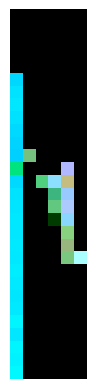

generated 8161 images


In [6]:
generated_images_model1 = create_generated_images(model, latent_dim1, six_dataset.shape, noise_uniform = True)

In [8]:
torch.save(generated_images_model1, "models/attempt1/6_branch_generated_trees.pt")

In [17]:
from useful_functions_notebook_8to13 import *
generated_images_model1 = torch.load("models/attempt1/6_branch_generated_trees.pt")

full_evaluation(generated_images_model1, dataset)

Analyzing generated merger tree dataset ...

			 CONSISTENCY CHECK


Percentage of consistant images = 9.69%



Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 90.00%
inconsistency due to distance not zero in main branch =  55.58%
inconsistency due to gap between branches =  26.66%
inconsistency due to zgap in branch 55.48%
inconsistency due to last descendant dont exist 1.14%

Number of images with two or more inconsistencies = 5952, which is  80.76%
That corresponds to 72.93% of all images


Of all images, 81.28% have zero inconsistency
Of all images, 50.19% have distance main branch inconsistency
Of all images, 24.08% have gap between branches inconsistency
Of all images, 50.10% have gap within branch inconsistency
Of all images, 1.03% have last descendant inconsistency

			 VARIABLE CONSISTENY CHECK of consistent trees
-------------------------------------------------------------------------------------------------------
MASS:
----------------------------------

In [18]:
cons, incons = check_consistency(generated_images_model1)



Percentage of consistant images = 9.69%



Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 90.00%
inconsistency due to distance not zero in main branch =  55.58%
inconsistency due to gap between branches =  26.66%
inconsistency due to zgap in branch 55.48%
inconsistency due to last descendant dont exist 1.14%

Number of images with two or more inconsistencies = 5952, which is  80.76%
That corresponds to 72.93% of all images


Of all images, 81.28% have zero inconsistency
Of all images, 50.19% have distance main branch inconsistency
Of all images, 24.08% have gap between branches inconsistency
Of all images, 50.10% have gap within branch inconsistency
Of all images, 1.03% have last descendant inconsistency


Real images:


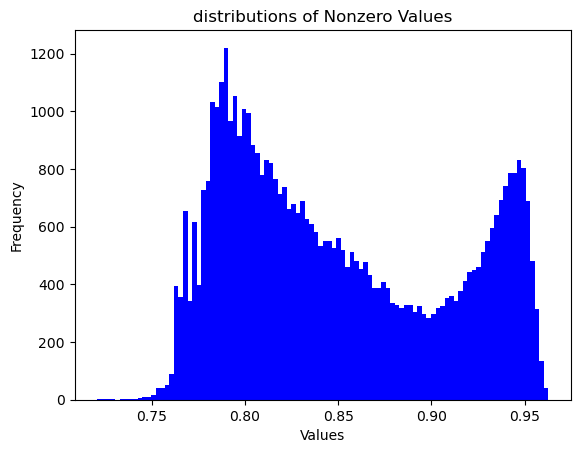

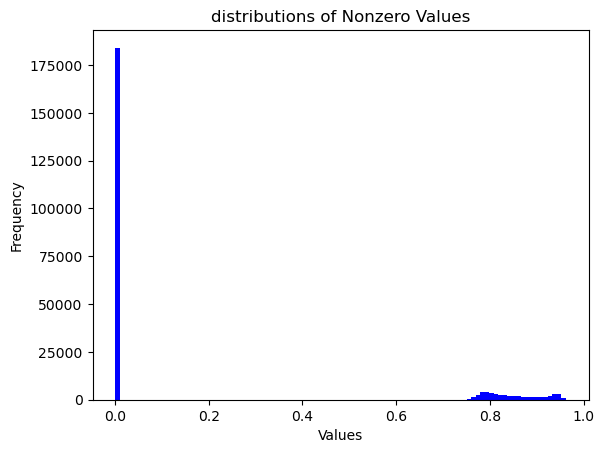

number of nonzero values = 47946
Generated images:


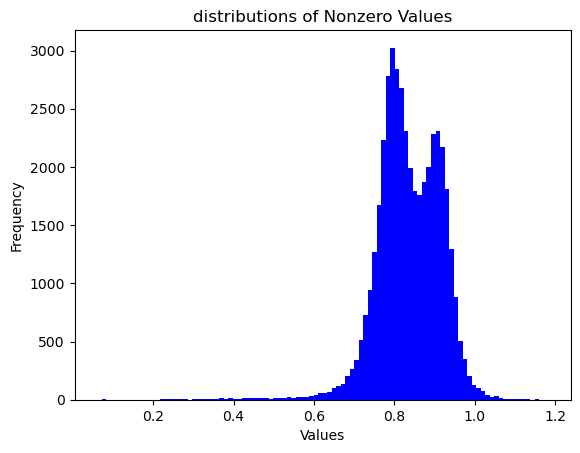

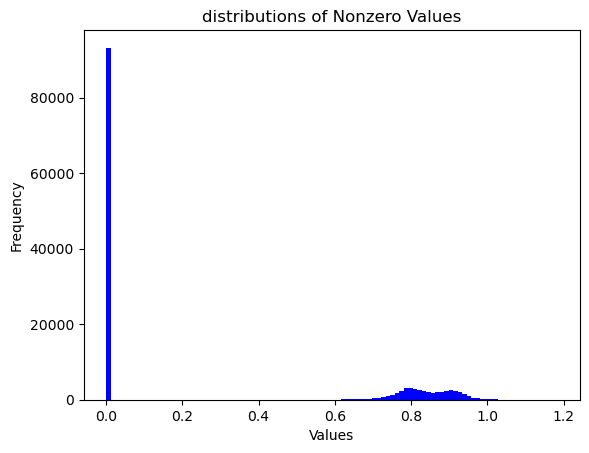

number of nonzero values = 44427


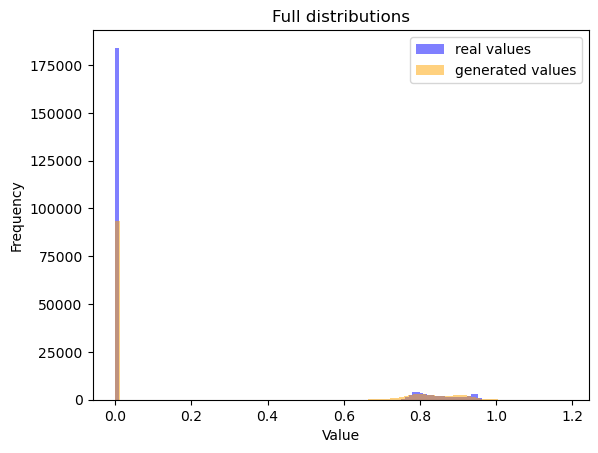

Full distribution:
KS Statistic: 0.11612708705697716
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0046:
The distributions are significantly different (reject H0), KS statistic 0.1161 > 0.0046


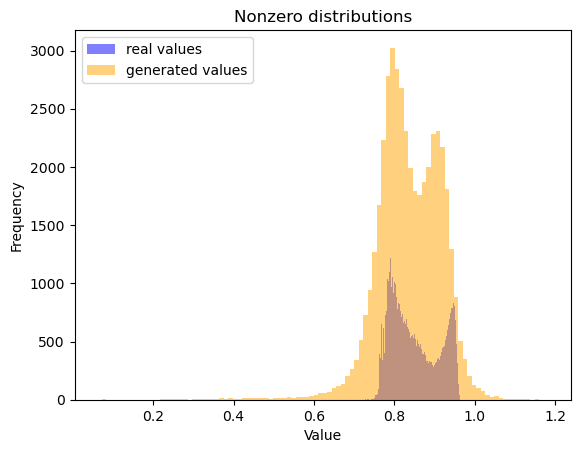

Nonzero distribution:
KS Statistic: 0.13120173006661215
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0089:
The distributions are significantly different (reject H0), KS statistic 0.1312 > 0.0089


(0.11612708705697716, 0.13120173006661215)

In [33]:
ks_test( six_branches[:800], cons, dim = 1)


Run 1 / 10:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


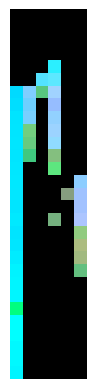

generated 8161 images


Percentage of consistant images = 9.81%

Run 2 / 10:
reconstructed image:


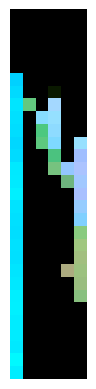

generated 8161 images


Percentage of consistant images = 10.61%

Run 3 / 10:
reconstructed image:


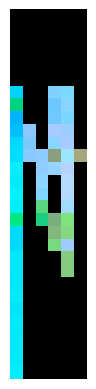

generated 8161 images


Percentage of consistant images = 10.57%

Run 4 / 10:
reconstructed image:


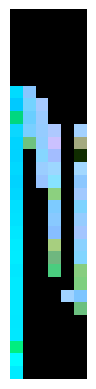

generated 8161 images


Percentage of consistant images = 9.64%

Run 5 / 10:
reconstructed image:


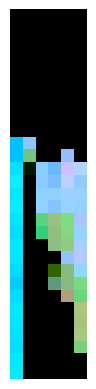

generated 8161 images


Percentage of consistant images = 9.29%

Run 6 / 10:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image:


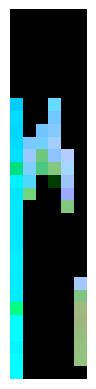

generated 8161 images


Percentage of consistant images = 10.06%

Run 7 / 10:
reconstructed image:


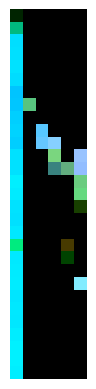

generated 8161 images


Percentage of consistant images = 9.74%

Run 8 / 10:
reconstructed image:


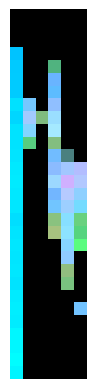

generated 8161 images


Percentage of consistant images = 10.45%

Run 9 / 10:
reconstructed image:


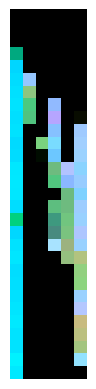

generated 8161 images


Percentage of consistant images = 10.44%

Run 10 / 10:
reconstructed image:


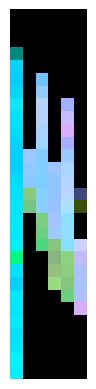

generated 8161 images


Percentage of consistant images = 10.53%
Constistancy average = 10.12%
Constistancy min = 9.29%
Constistancy max = 10.61%


In [25]:
consistancy = []
for i in range(10):
    print(f"\nRun {i + 1} / 10:")
    generated_images_model1 = create_generated_images(model, latent_dim1, six_dataset.shape, noise_uniform = True)
    consist_data, inconsistent_images, percentage = check_consistency(generated_images_model1)
    consistancy.append(percentage)
    
consistancy = torch.tensor(consistancy, dtype=torch.float32)
    
print(f"Constistancy average = {consistancy.mean():.2f}%")
print(f"Constistancy min = {consistancy.min():.2f}%")
print(f"Constistancy max = {consistancy.max():.2f}%")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image 36:


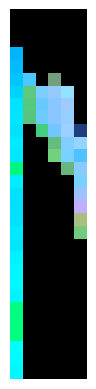

image 580:


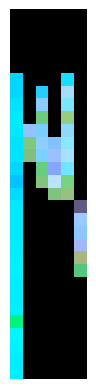

image 123:


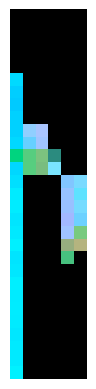

In [78]:
images = plot_images(consist_data, 3)

Real images:


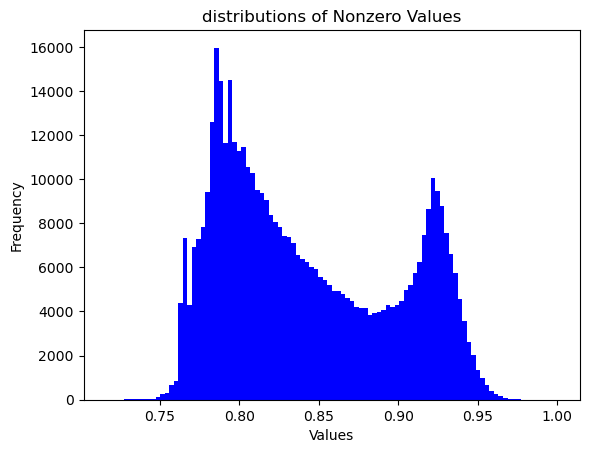

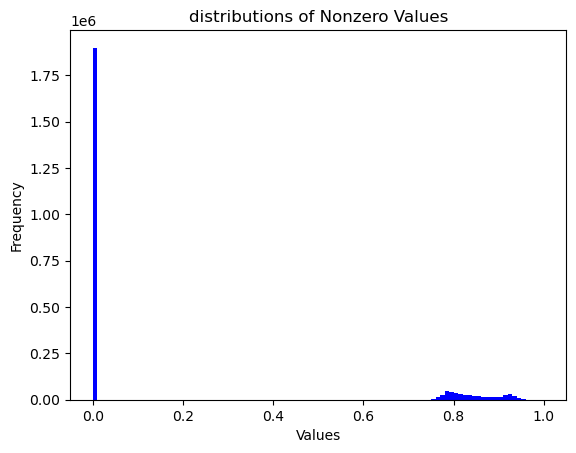

number of nonzero values = 468178
Generated images:


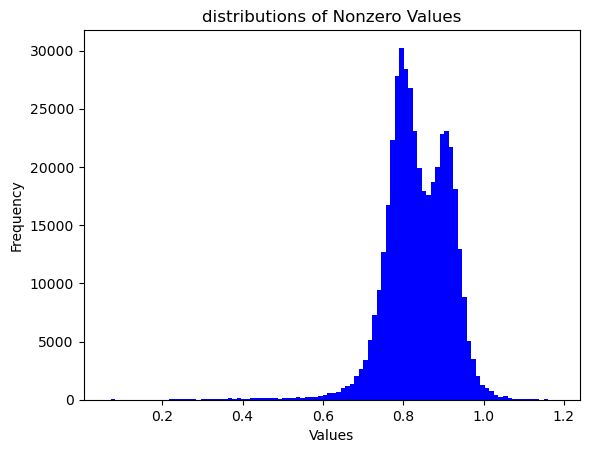

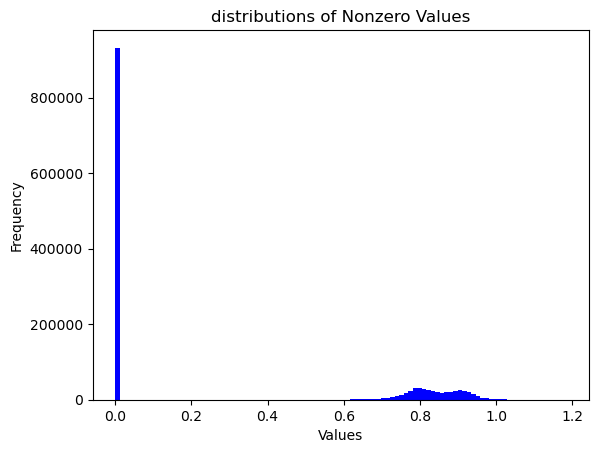

number of nonzero values = 444270


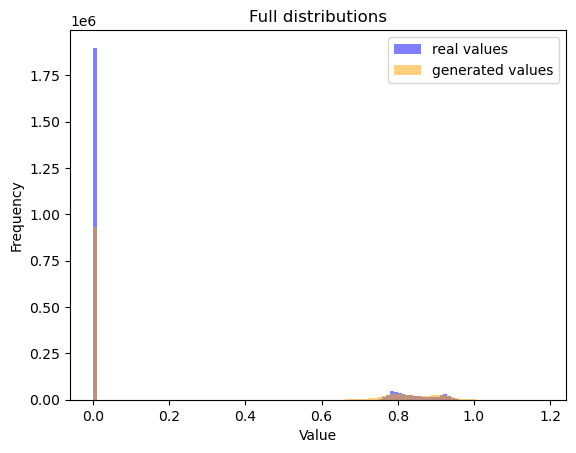

Full distribution:
KS Statistic: 0.1249711403550432
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0015:
The distributions are significantly different (reject H0), KS statistic 0.1250 > 0.0015


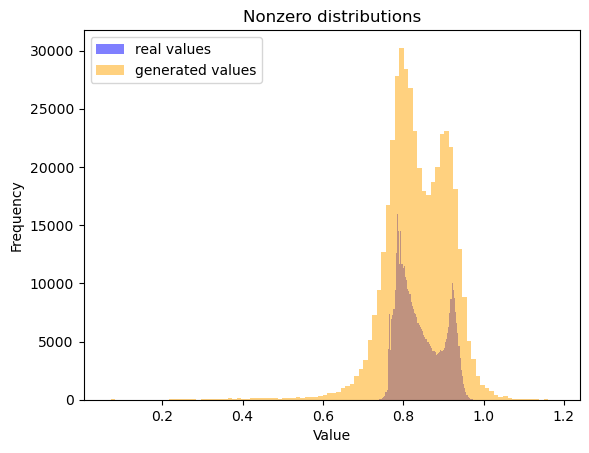

Nonzero distribution:
KS Statistic: 0.13146569891491
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0028:
The distributions are significantly different (reject H0), KS statistic 0.1315 > 0.0028


(0.1249711403550432, 0.13146569891491)

In [6]:
test = torch.cat([consist_data, consist_data, consist_data, consist_data, consist_data, consist_data,
                 consist_data, consist_data, consist_data, consist_data])
ks_test(six_branches, test.detach(), dim = 1)

In [37]:
variable = cons[:, 1]

# extract nonzero values
nonzero_indices = torch.nonzero(variable.flatten())
nonzero_value = variable.flatten()[nonzero_indices[:, 0]]
print(nonzero_value.mean().item(), nonzero_value.min().item(), nonzero_value.max().item(), nonzero_value.sum().item())

variable = six_branches[:, 1]

# extract nonzero values
nonzero_indices = torch.nonzero(variable.flatten())
nonzero_value_six = variable.flatten()[nonzero_indices[:, 0]]
print(nonzero_value_six.mean().item(), nonzero_value_six.min().item(), nonzero_value_six.max().item())


len(nonzero_value), len(nonzero_value_six.flatten().numpy()), nonzero_value.max()

0.8362206816673279 0.06066314876079559 1.1830883026123047 37150.77734375
0.8432592954678704 0.7161649025418501 1.0


(44427, 468178, tensor(1.1831))

In [35]:
mask = (nonzero_value > 0.7161649025418501 ) & (nonzero_value < 1.0)

# Count the number of True values in the mask
count = torch.sum(mask).item()
count * 100 / len(nonzero_value)

94.75319062732122

# boost consistency

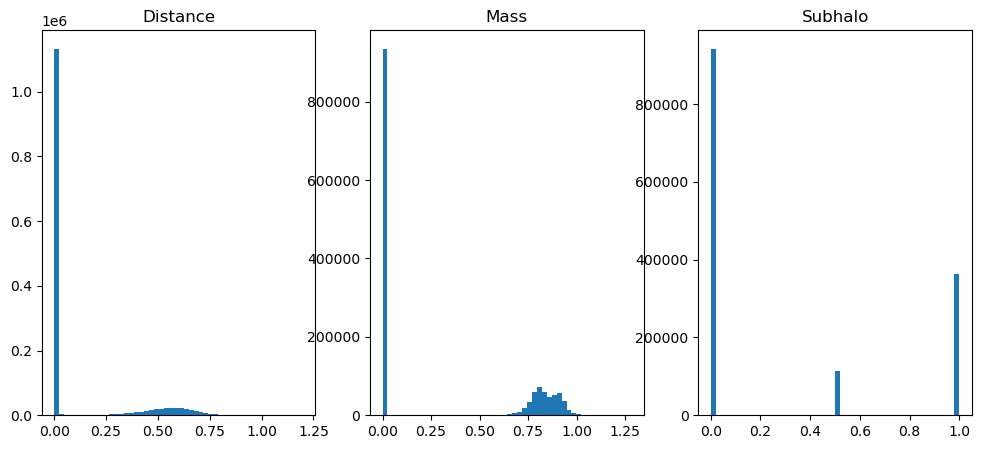

In [38]:
import torch

data = torch.load("models/attempt1/6_branch_generated_trees.pt")

dist = data[:, 0]
mass = data[:, 1]
subh = data[:, 2]

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Display the first image in the first subplot
axs[0].hist(dist.numpy().flatten(), bins = 50)
axs[0].set_title('Distance')

# Display the second image in the second subplot
axs[1].hist(mass.numpy().flatten(), bins = 50)
axs[1].set_title('Mass')

# Display the second image in the second subplot
axs[2].hist(subh.numpy().flatten(), bins = 50)
axs[2].set_title('Subhalo')

plt.show()

In [39]:
# dist
print("dist:")
lower_threshold = 0.1
upper_threshold = 0.2
count_between_thresholds = torch.sum((dist > lower_threshold) & (dist < upper_threshold)).item()
total_elements = dist.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")

print("mass:")
lower_threshold = 0.1
upper_threshold = 0.5
count_between_thresholds = torch.sum((mass > lower_threshold) & (mass < upper_threshold)).item()
total_elements = mass.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")

dist:
Percentage of values between 0.1 and 0.2: 0.29%

mass:
Percentage of values between 0.1 and 0.5: 0.44%



In [45]:
0.6985
data = transform_diffusion_image(data, d_thresh = 0.2, m_tresh = 0.5, s_low = 0.3, s_high = 0.77)

original_min = 0.6985
mass = data[:, 1]
nonzero_indices = torch.nonzero(mass.flatten())
nonzero_mass = mass.flatten()[nonzero_indices[:, 0]]
print("mass:")
count_between_thresholds = torch.sum(nonzero_mass < original_min).item()
total_elements = mass.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values below {original_min}: {percentage_between_thresholds:.2f}%\n")

mass:
Percentage of values below 0.6985: 1.00%



In [23]:
data = transform_diffusion_image(data, d_thresh = 0.2, m_tresh = 0.5, s_low = 0.3, s_high = 0.77)

original_min = 0.7161649025418501
mass = data[:, 1]
nonzero_indices = torch.nonzero(mass.flatten())
nonzero_mass = mass.flatten()[nonzero_indices[:, 0]]
print("mass:")
count_between_thresholds = torch.sum(nonzero_mass < original_min).item()
total_elements = mass.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values below {original_min}: {percentage_between_thresholds:.2f}%\n")

full_evaluation(data, dataset)

mass:
Percentage of values below 0.6985: 1.00%

Analyzing generated merger tree dataset ...

			 CONSISTENCY CHECK


Percentage of consistant images = 17.63%



Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 80.05%
inconsistency due to distance not zero in main branch =  0.03%
inconsistency due to gap between branches =  31.37%
inconsistency due to zgap in branch 52.68%
inconsistency due to last descendant dont exist 0.60%

Number of images with two or more inconsistencies = 3707, which is  55.15%
That corresponds to 45.42% of all images


Of all images, 65.94% have zero inconsistency
Of all images, 0.02% have distance main branch inconsistency
Of all images, 25.84% have gap between branches inconsistency
Of all images, 43.39% have gap within branch inconsistency
Of all images, 0.49% have last descendant inconsistency

			 VARIABLE CONSISTENY CHECK of consistent trees
-------------------------------------------------------------------------------------------------

In [46]:
cons, icon = check_consistency(data)



Percentage of consistant images = 17.63%



Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 80.05%
inconsistency due to distance not zero in main branch =  0.03%
inconsistency due to gap between branches =  31.37%
inconsistency due to zgap in branch 52.68%
inconsistency due to last descendant dont exist 0.60%

Number of images with two or more inconsistencies = 3707, which is  55.15%
That corresponds to 45.42% of all images


Of all images, 65.94% have zero inconsistency
Of all images, 0.02% have distance main branch inconsistency
Of all images, 25.84% have gap between branches inconsistency
Of all images, 43.39% have gap within branch inconsistency
Of all images, 0.49% have last descendant inconsistency


Real images:


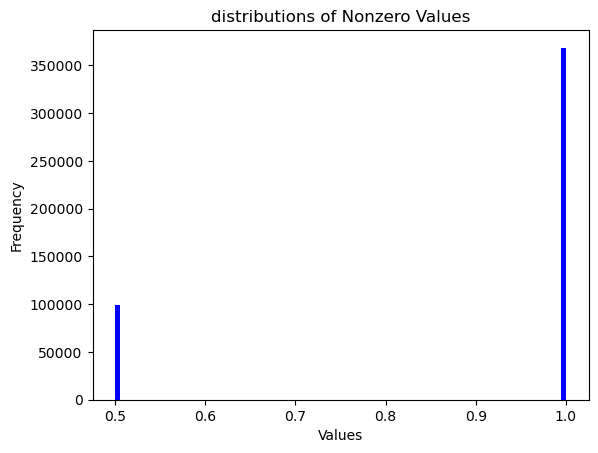

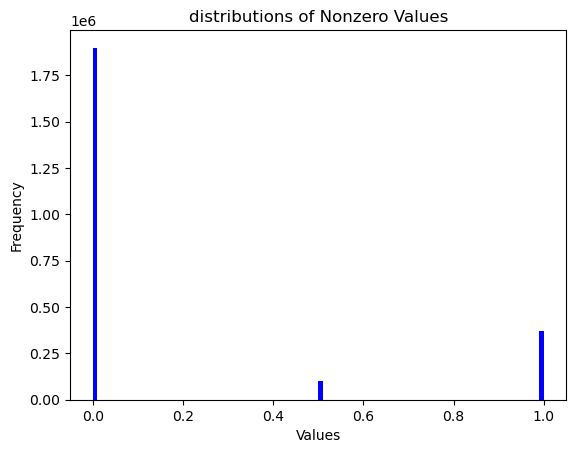

number of nonzero values = 468178
Generated images:


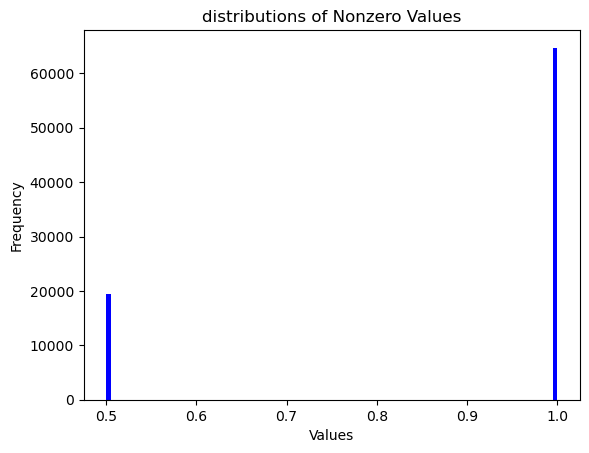

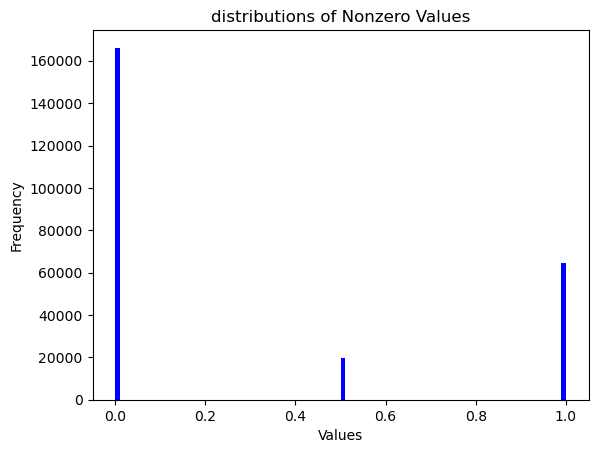

number of nonzero values = 84225


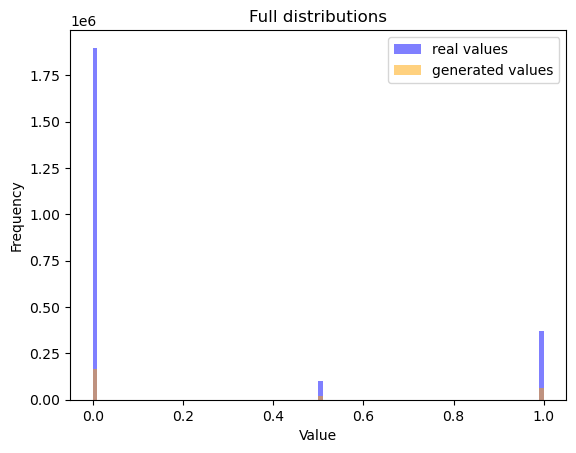

Full distribution:
KS Statistic: 0.13856088850450732
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0029:
The distributions are significantly different (reject H0), KS statistic 0.1386 > 0.0029


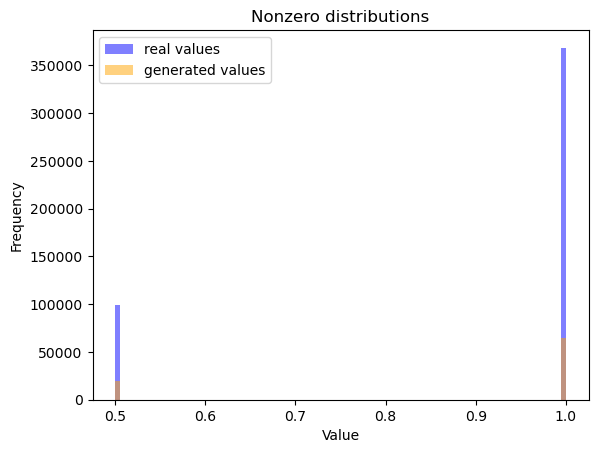

Nonzero distribution:
KS Statistic: 0.01913213720986326
P-value: 3.9664910566694426e-23

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0051:
The distributions are significantly different (reject H0), KS statistic 0.0191 > 0.0051


(0.13856088850450732, 0.01913213720986326)

In [48]:
ks_test(six_branches, cons, dim = 2)